In [1]:
! pip install --upgrade cka-pytorch

  Attempting uninstall: cka-pytorch
    Found existing installation: cka-pytorch 0.1.5
    Uninstalling cka-pytorch-0.1.5:
      Successfully uninstalled cka-pytorch-0.1.5


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18
from tqdm.autonotebook import tqdm
from copy import deepcopy

/tmp/ipython-input-2-2226080857.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Setup DataLoader and Models

An important detail is that although we are using the Validation set for `CIFAR10`, we **shuffle** and drop the last batch. This is to ensure that 1) the batches of each epoch are mixed, and 2) each iteration has the same batch size.

In [3]:
transforms = Compose([ToTensor(),
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = CIFAR10(root='./', train=False, download=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
model1 = resnet18(pretrained=True).cuda()
model1.eval()
model2 = deepcopy(model1).cuda()
model2.eval()
print('Dummy models created')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dummy models created


## Compute CKA

In [5]:
from cka_pytorch import CKACalculator

### Basic Usage

Initializing the `CKACalculator` object will add forward hooks to both `model1` and `model2`.
The default modules that are hooked are: `Bottleneck`, `BasicBlock`, `Conv2d`, `AdaptiveAvgPool2d`, `MaxPool2d`, and all instances of `BatchNorm`.
Note that `Bottleneck` and `BasicBlock` are from the `torchvision` implementation, and will not add hooks to any custom implementations of `Bottleneck/BasicBlock`.

For ResNet18, a total of 50 hooks are added.

By default, the intermediate features are flattened with `flatten_hook_fn` and 10 epochs are run.

In [6]:
calculator = CKACalculator(model1=model1, model2=model2, dataloader=dataloader)

Now we can calculate the CKA matrix

In [7]:
cka_output = calculator.calculate_cka_matrix()
print(f"CKA output size: {cka_output.size()}")

Epoch 1/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/10:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


CKA output size: torch.Size([50, 50])


Extract hooked module names. By default, all layers will be hooked.

In [8]:
for i, name in enumerate(calculator.module_names_x):
    print(f"Layer {i}: \t{name}")

Layer 0: 	conv1
Layer 1: 	bn1
Layer 2: 	maxpool
Layer 3: 	layer1.0.conv1
Layer 4: 	layer1.0.bn1
Layer 5: 	layer1.0.conv2
Layer 6: 	layer1.0.bn2
Layer 7: 	layer1.0
Layer 8: 	layer1.1.conv1
Layer 9: 	layer1.1.bn1
Layer 10: 	layer1.1.conv2
Layer 11: 	layer1.1.bn2
Layer 12: 	layer1.1
Layer 13: 	layer2.0.conv1
Layer 14: 	layer2.0.bn1
Layer 15: 	layer2.0.conv2
Layer 16: 	layer2.0.bn2
Layer 17: 	layer2.0.downsample.0
Layer 18: 	layer2.0.downsample.1
Layer 19: 	layer2.0
Layer 20: 	layer2.1.conv1
Layer 21: 	layer2.1.bn1
Layer 22: 	layer2.1.conv2
Layer 23: 	layer2.1.bn2
Layer 24: 	layer2.1
Layer 25: 	layer3.0.conv1
Layer 26: 	layer3.0.bn1
Layer 27: 	layer3.0.conv2
Layer 28: 	layer3.0.bn2
Layer 29: 	layer3.0.downsample.0
Layer 30: 	layer3.0.downsample.1
Layer 31: 	layer3.0
Layer 32: 	layer3.1.conv1
Layer 33: 	layer3.1.bn1
Layer 34: 	layer3.1.conv2
Layer 35: 	layer3.1.bn2
Layer 36: 	layer3.1
Layer 37: 	layer4.0.conv1
Layer 38: 	layer4.0.bn1
Layer 39: 	layer4.0.conv2
Layer 40: 	layer4.0.bn2
Layer 4

#### Visualize the output

Note that the returned matrix has its origin at the top left. In most papers, the CKA matrix is visualized with its origin at the bottom left. Thus, we may flip the matrix first before visualization; however, this example chooses not to.

<Axes: >

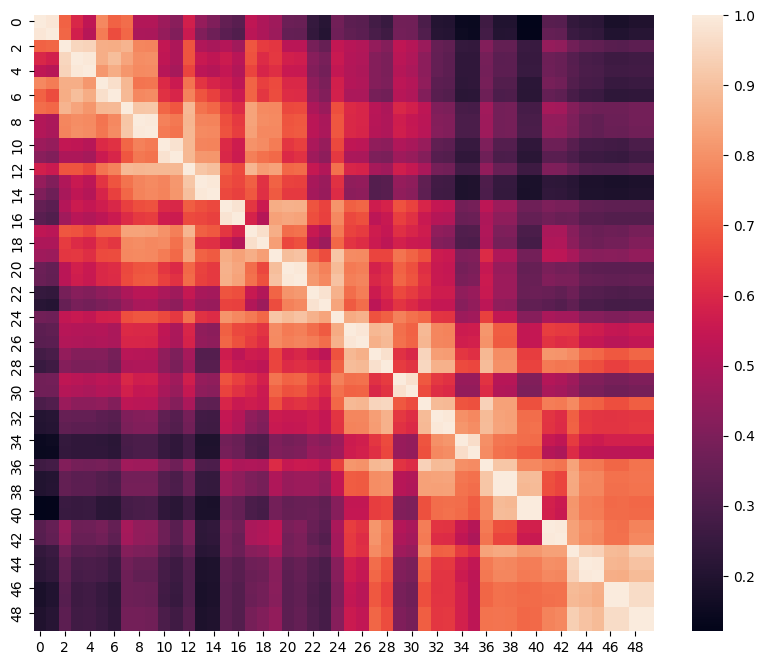

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cka_output.cpu().numpy(), ax=ax)

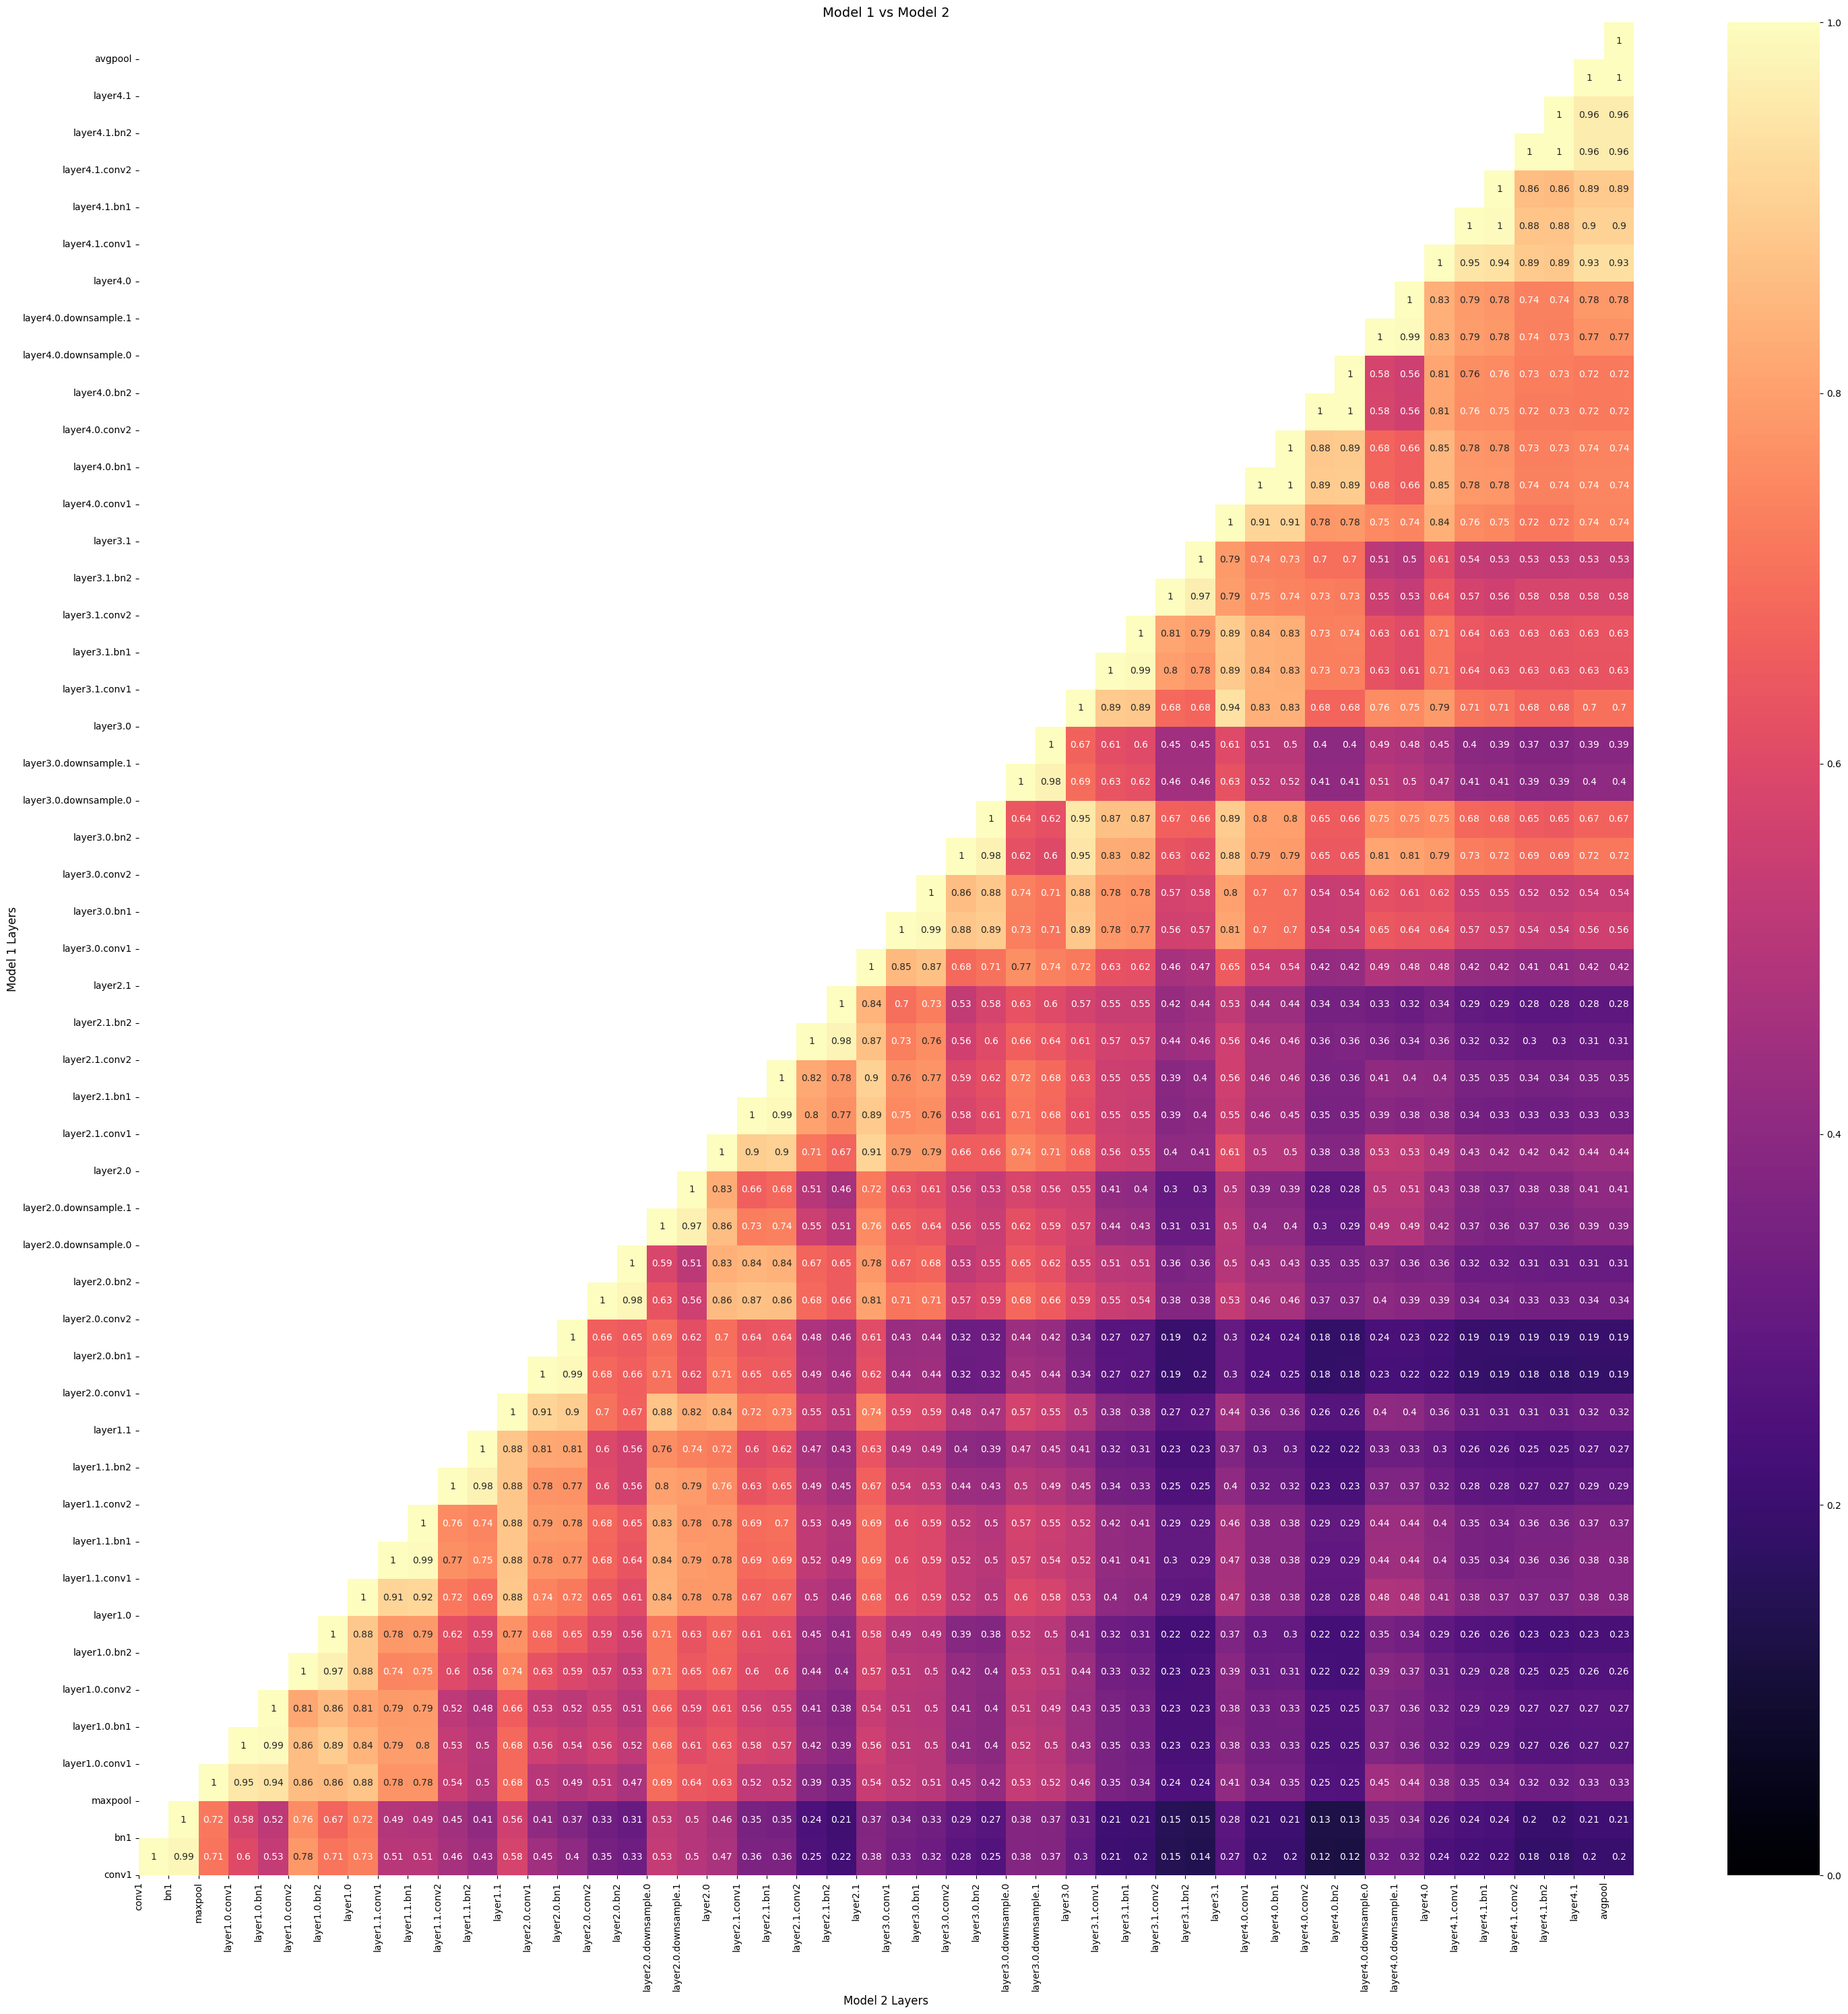

In [14]:
calculator.plot_cka_matrix(figsize=(30, 30), show_half_heatmap=True, invert_y_axis=True)

### Advanced Usage

We can customize other parameters of the `CKACalculator`.
Most importantly, we can select which modules to hook.

Before instantiating a new instance of `CKACalculator` on, make sure to first call the `reset` method.
This clears all hooks registered in the models.

In [15]:
# Reset calculator to clear hooks
calculator.reset()
torch.cuda.empty_cache()

In [16]:
import torch.nn as nn

Let's consider outputs of `Conv2d` and `BatchNorm2d` only. This will create 40 hooks.

For custom layers, add the custom modules in the same manner as shown below.

In [23]:
layers = (nn.Conv2d,)

In [24]:
calculator = CKACalculator(model1=model1, model2=model2, dataloader=dataloader, hook_layer_types=layers)

In [25]:
cka_output = calculator.calculate_cka_matrix()

Epoch 1/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/10:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### Visualize output

<Axes: >

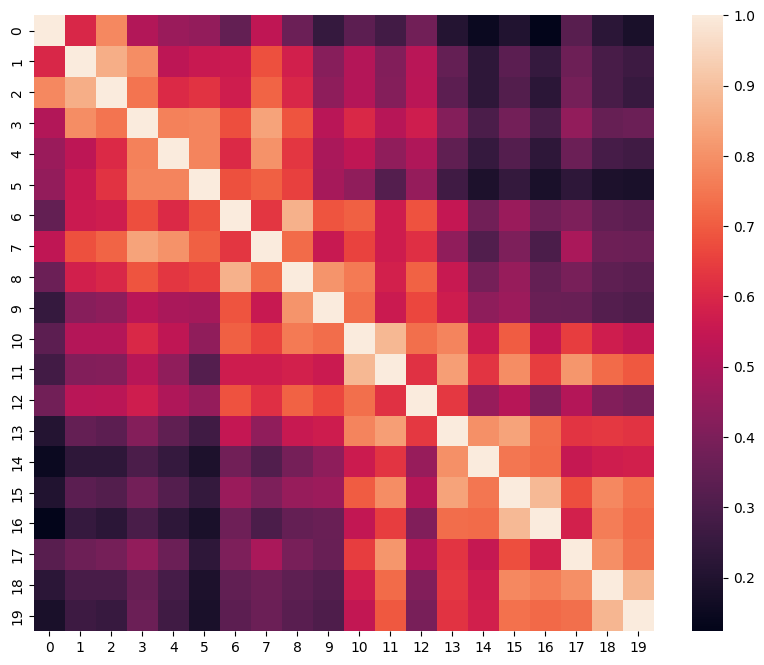

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cka_output.cpu().numpy(), ax=ax)

#### Extract module names

In [27]:
for i, name in enumerate(calculator.module_names_x):
    print(f"Layer {i}: \t{name}")

Layer 0: 	conv1
Layer 1: 	layer1.0.conv1
Layer 2: 	layer1.0.conv2
Layer 3: 	layer1.1.conv1
Layer 4: 	layer1.1.conv2
Layer 5: 	layer2.0.conv1
Layer 6: 	layer2.0.conv2
Layer 7: 	layer2.0.downsample.0
Layer 8: 	layer2.1.conv1
Layer 9: 	layer2.1.conv2
Layer 10: 	layer3.0.conv1
Layer 11: 	layer3.0.conv2
Layer 12: 	layer3.0.downsample.0
Layer 13: 	layer3.1.conv1
Layer 14: 	layer3.1.conv2
Layer 15: 	layer4.0.conv1
Layer 16: 	layer4.0.conv2
Layer 17: 	layer4.0.downsample.0
Layer 18: 	layer4.1.conv1
Layer 19: 	layer4.1.conv2


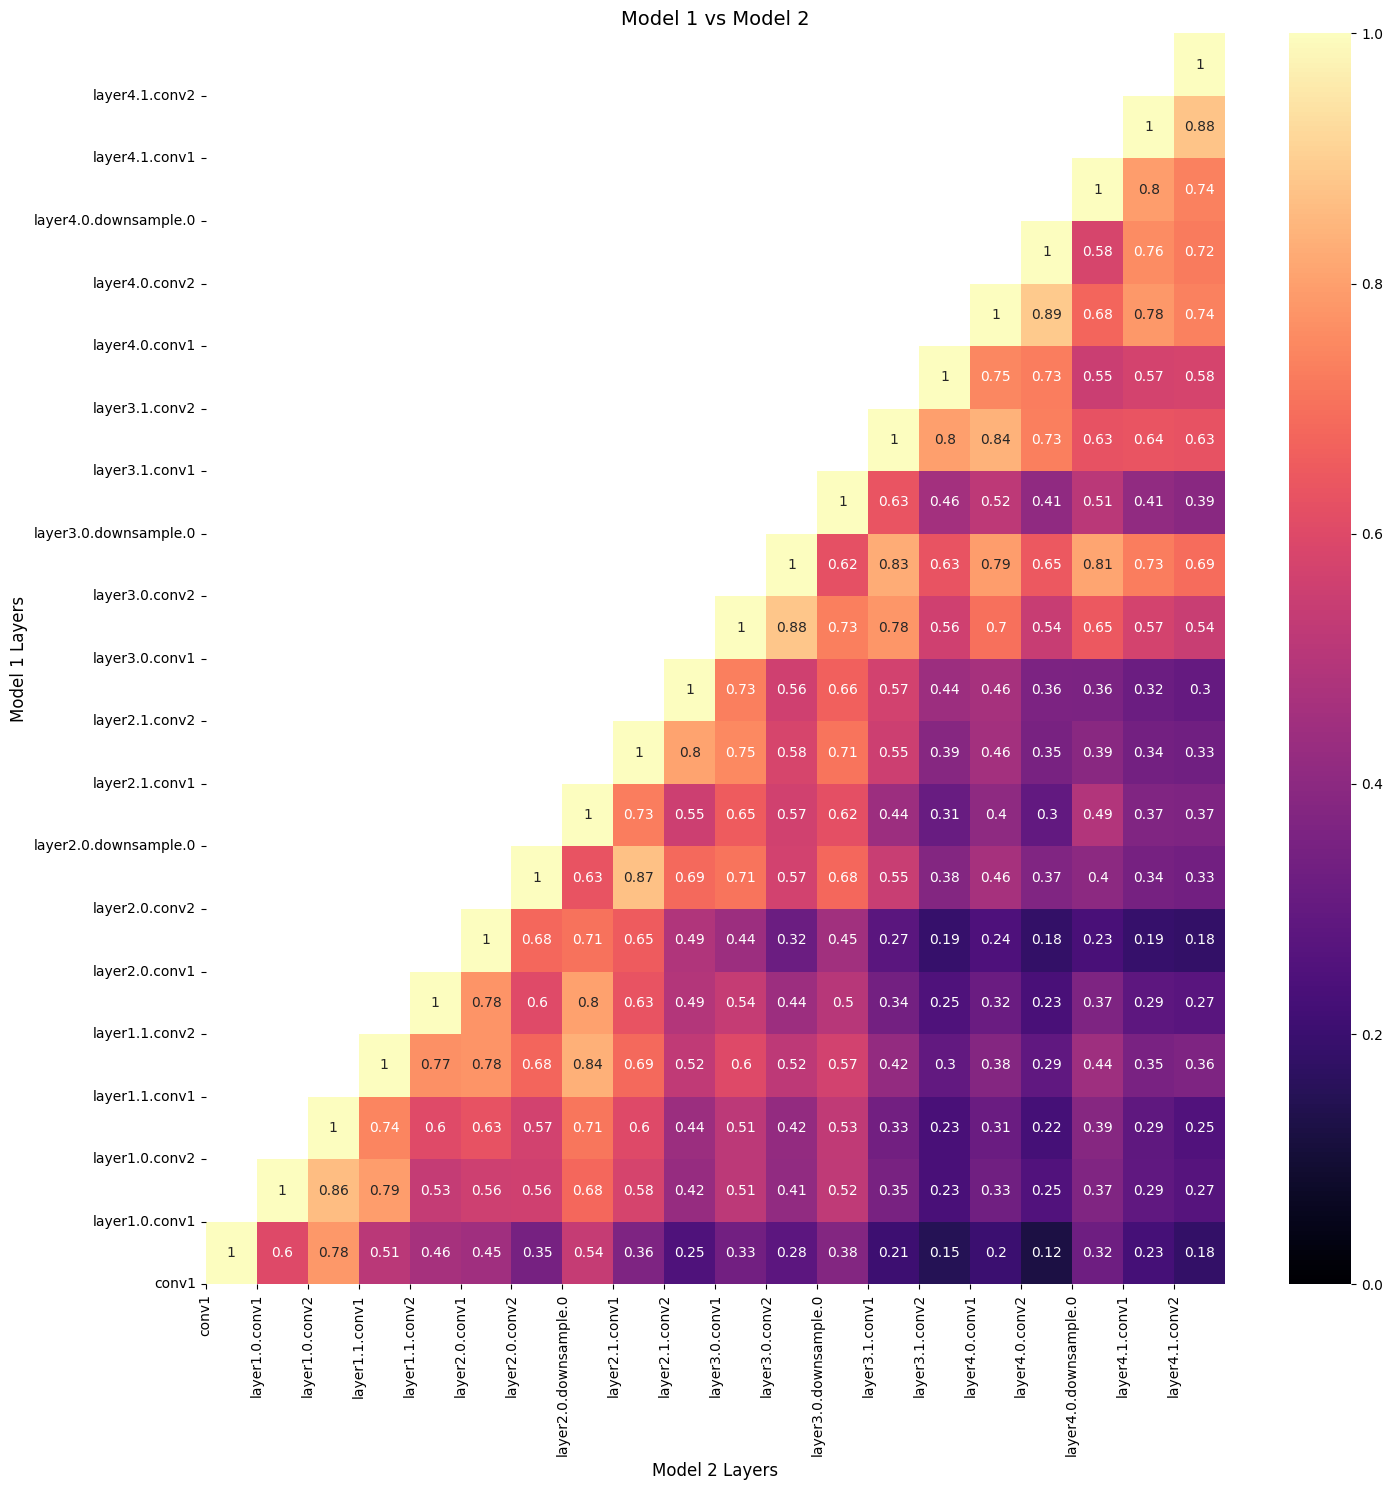

In [31]:
calculator.plot_cka_matrix(figsize=(15, 15), show_half_heatmap=True, invert_y_axis=True)